# Notebook 1 — Prétraitement des images

## Objectif
Ce notebook a pour but de préparer les images du projet Doppleganger avant leur passage dans un modèle de Deep Learning.

Les étapes réalisées sont :
- chargement des images brutes,
- détection et recadrage des visages,
- normalisation des images,
- sauvegarde des visages traités.

Deux sources de données sont utilisées :
- le dataset public FairFace,
- les photos personnelles du groupe.


In [1]:
import os
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

import torch
from facenet_pytorch import MTCNN

d:\Mes_dossiers\IDSI\M2\Course\RN & DL\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Explications

Pathlib : gestion propre des chemins

PIL : ouverture et manipulation des images

matplotlib : visualisation

facenet-pytorch / MTCNN :

- détecteur de visages pré-entraîné

- robuste et standard en reconnaissance faciale

MTCNN ≠ modèle de reconnaissance, c’est juste un détecteur.

In [8]:
BASE_DIR = Path("../data")

RAW_FAIRFACE = BASE_DIR / "raw" / "fairface"
RAW_OUR_FACES = BASE_DIR / "raw" / "our_faces"

PROC_FAIRFACE = BASE_DIR / "processed" / "fairface_faces"
PROC_OUR_FACES = BASE_DIR / "processed" / "our_faces"

PROC_FAIRFACE.mkdir(parents=True, exist_ok=True)
PROC_OUR_FACES.mkdir(parents=True, exist_ok=True)


In [9]:
def count_images(folder):
    return len(list(folder.rglob("*.jpg"))) + len(list(folder.rglob("*.png")))

print("Images FairFace :", count_images(RAW_FAIRFACE))
print("Images personnelles :", count_images(RAW_OUR_FACES))


Images FairFace : 97698
Images personnelles : 21


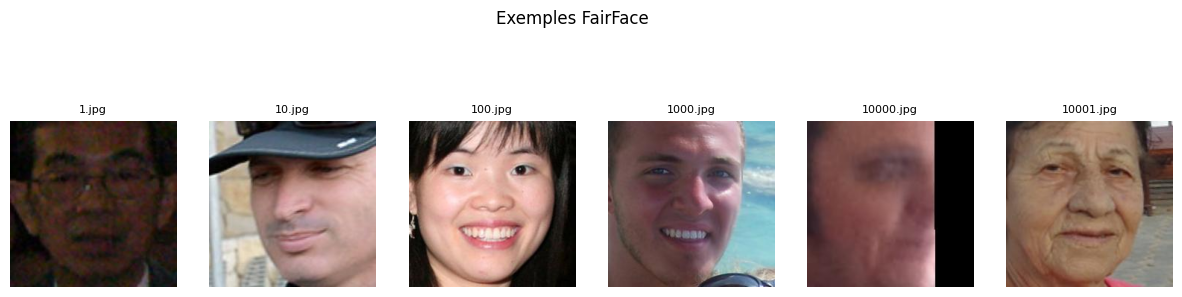

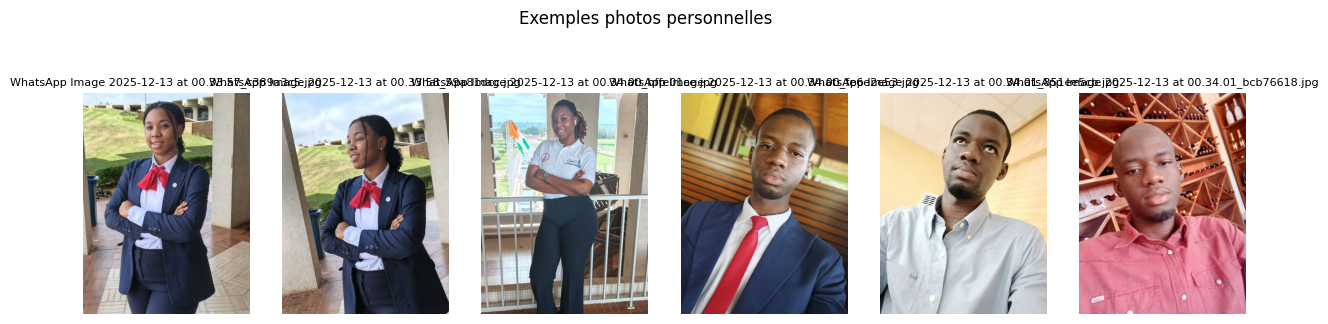

In [10]:
def show_images(image_paths, n=6, title="Images"):
    fig, axes = plt.subplots(1, n, figsize=(15,4))
    for ax, p in zip(axes, image_paths[:n]):
        img = Image.open(p).convert("RGB")
        ax.imshow(img)
        ax.set_title(p.name, fontsize=8)
        ax.axis("off")
    plt.suptitle(title)
    plt.show()

# Exemples FairFace
fairface_imgs = list(RAW_FAIRFACE.rglob("*.jpg"))
show_images(fairface_imgs, title="Exemples FairFace")

# Exemples photos personnelles
our_imgs = list(RAW_OUR_FACES.rglob("*.jpg"))
show_images(our_imgs, title="Exemples photos personnelles")


## Initialisation du détecteur de visage

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"

mtcnn = MTCNN(
    image_size=160,
    margin=0,
    keep_all=False,
    device=device
)

print("Device utilisé :", device)


Device utilisé : cuda


d:\Mes_dossiers\IDSI\M2\Course\RN & DL\.venv\Lib\site-packages\facenet_pytorch\models\mtcnn.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(stat

## Fonction de détection et recadrage

In [12]:
def detect_and_crop(image_path, output_path):
    img = Image.open(image_path).convert("RGB")
    face = mtcnn(img)

    if face is None:
        return False

    # conversion tensor → image
    face = face.permute(1,2,0)
    face = (face + 1) / 2
    face = (face * 255).byte().numpy()

    Image.fromarray(face).save(output_path)
    return True


## Prétraitement des photos personnelles

In [13]:
for person_dir in RAW_OUR_FACES.iterdir():
    if not person_dir.is_dir():
        continue

    out_dir = PROC_OUR_FACES / person_dir.name
    out_dir.mkdir(exist_ok=True)

    for img_path in person_dir.glob("*.jpg"):
        out_path = out_dir / img_path.name
        success = detect_and_crop(img_path, out_path)

        if not success:
            print("Visage non détecté :", img_path)


## Prétraitement de FairFace

In [14]:
for img_path in RAW_FAIRFACE.rglob("*.jpg"):
    out_path = PROC_FAIRFACE / img_path.name
    detect_and_crop(img_path, out_path)


KeyboardInterrupt: 

## Vérification des résultats

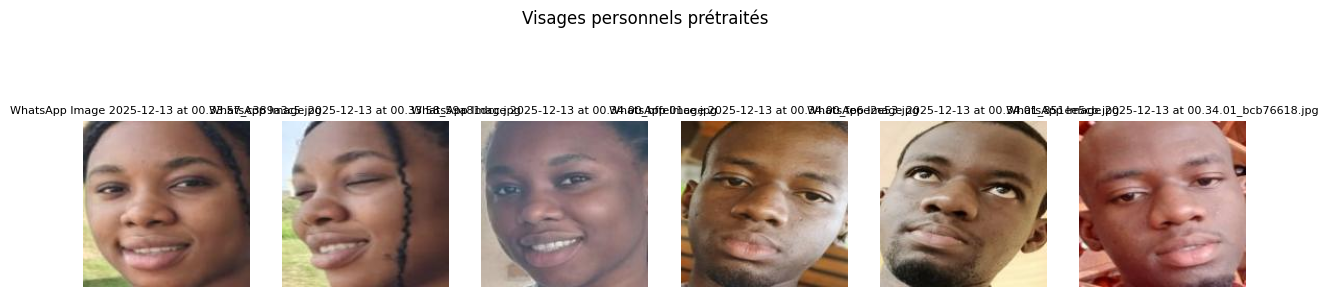

In [15]:
processed_imgs = list(PROC_OUR_FACES.rglob("*.jpg"))
show_images(processed_imgs, title="Visages personnels prétraités")